### Project: Using Neural Networks and Deep Learning for Disease Recognition Using Ocular Images

* Juwonlo Siyanbade

### Abstract

The notebook contains a model developed to analyze the ocular images and detect whether an eye image is mormal or has cataract. The dataset contains quality controlled human anotataed image data clasifying eye images into different labels. The system developed can be used by medical experts to validate diagnosis, or for initial diagnosis. Convolutional Neural Network and VGG16 for transfer learning were used to create the model. The images were loaded to the network using the image generator and split into 25% for testing and 75% for training- 20% of which was used for validation. The evaluation of the model shows that the model has an accuracy of 89.86%. It was able to accurately classify 257 of the 286 images in the test data. Looking at the confusion matrix, the critical result is the 8 false positives in the prediction (8 images labelled as normal but are cataract). Overall, the performance of the model is very good and can be safely implemented in real-life application.

### Use Case

Medical experts have tried to accurately detect and diagnose diseases based on examinations, tests, scans, and images. These diagnoses are time-consuming and are subject to human errrors. Misclassification can be fatal and late diagnosis can be life-threatning. To utilize the power of computers, I have been approached to develop a system to diagnose an eye disease- cataract based on the eye image. The system will be trained on the human annotated ocular images dataset to classify normal eye images and cataract eye images. A system can be built on this to accelerate the diagnosis on eye diseases and expanded to include other dieases.

### Data Selection

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, **color fundus photographs** from left and right eyes and doctors' diagnostic keywords. Annotations (diagnosis) were labeled by trained human readers with quality control management. They classify patients' eye images into eight labels which are:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

The real-life dataset was collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China.

Data link: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k

#### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Data preparation and exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# VGG pre-trained model only accepts a 224 x 224 image size
img_size = 224

In [ ]:
# Import csv file from data file
df_data = pd.read_csv("/content/drive/MyDrive/Dataset/NN/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


#### Exploratory data analysis

It can be observed from the table above that the eye images are separated into left and right. However, the 'one-hot' encoded columns labeled with single alphabets (N, D, G, etc.) does not provide information on the eye with the disease. The blanket idea is that if either eye has a diagnosis, it is labelled as 1 (true), else 0 (false). This is not an issue with all queries but will be an issue when we need to use the image files.
Therefore, the diagnostic keywords will be the more reliable source of data.


In [ ]:
# Examine images that have cataract as diagnosis
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


It is safe to say that if either eye has a cataract, it is properly labeled in the keywords column of that eye with the word "cataract".  The encoded columns will be discarded since they do not provide accurate mapping to our left/right eye requirements when we process the left/right images.

In [ ]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


#### Set up image file path



In [ ]:
img_dir= "/content/drive/MyDrive/Dataset/NN/preprocessed_images"

Select only Cataract related data for each eye

In [ ]:
# Put Left-Diagnostic Keywords = cataract into a dataframe
df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
df_left_cat.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [ ]:
print(len(df_left_cat))

294


In [ ]:
# Put Right-Diagnostic Keywords = cataract into a dataframe
df_right_cat =df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')]
df_right_cat.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [ ]:
print(len(df_right_cat))

278


#### Combine cataract images column from the left and right dataframe for easy processing

In [ ]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_right_cat['Right-Fundus'], ignore_index=True)
# Shuffle the files
df_cat_filenames= df_cat_filenames.sample(frac=1).reset_index(drop=True)

In [ ]:
# Let's find out how many rows of cataract images we're working with

len(df_cat_filenames)

572

#### View example images from cataract image dataframe

Note that when the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red).  Select random image from dataframe.

(512, 512, 3)
2170_right.jpg


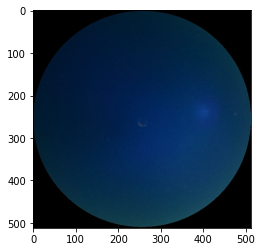

In [ ]:
img = df_cat_filenames[65]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

#### Create a grid of some images

From the cataract image set, collect some images to examine cataract diagnosis using the coloful pallette

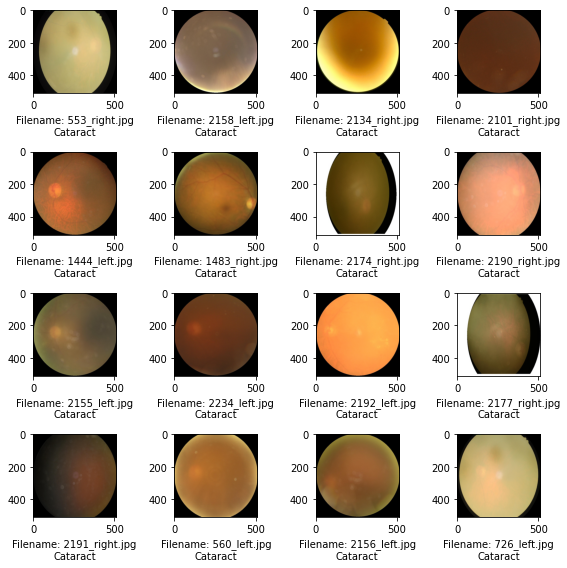

In [ ]:
plt.figure(figsize=(8,8))
for i in range(16):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(4,4,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout()

#### Select only the normal eye images


In [ ]:
# Put Left-Diagnostic Keywords = normal into a dataframe
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
df_left_norm.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
8,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration
12,55,Male,14_left.jpg,14_right.jpg,normal fundus,macular epiretinal membrane
13,50,Male,15_left.jpg,15_right.jpg,normal fundus,myelinated nerve fibers


In [ ]:
print(len(df_left_norm))

2855


In [ ]:
# Put Right-Diagnostic Keywords = normal into a dataframe
df_right_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
df_right_norm.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
9,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus
24,59,Male,29_left.jpg,29_right.jpg,epiretinal membrane,normal fundus


In [ ]:
print(len(df_right_norm))

2735


#### Combine cataract images column from the left and right dataframe for easy processing.

In [ ]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_right_norm['Right-Fundus'], ignore_index=True)
len(df_norm_filenames)

5590

There are 5590 normal eye images in the data. Using this quantity of data may affect the learning pattern of the model. Therefore, an equal number of images to correspond with the size of cataract images (572) will be seleted at random.

#### Select a random set of images from the normal eye data images

In [ ]:
# 572 normal data are selected to equal the number of cataract images for the a new object
df_norm_filenames_random = df_norm_filenames.sample(n = 572)

# Reset index
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)

# Preview selected data
df_norm_filenames_random.head()


0    2951_left.jpg
1    3389_left.jpg
2    2409_left.jpg
3    379_right.jpg
4    2985_left.jpg
dtype: object

#### Create a grid of normal eye images

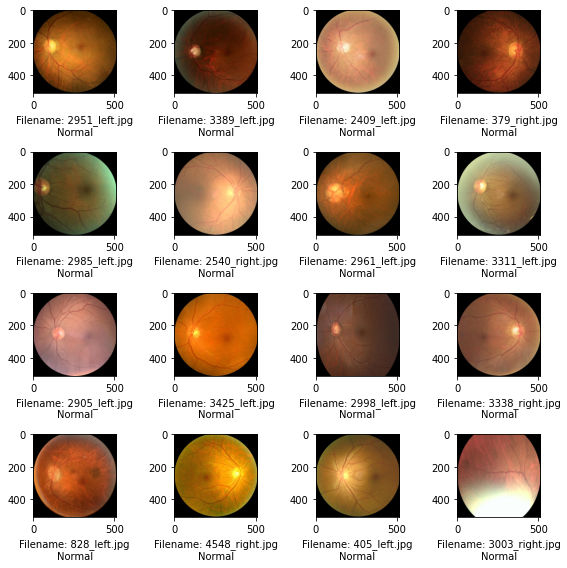

In [ ]:
plt.figure(figsize=(8,8))
for i in range(16):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    # Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(4,4,i+1)
    plt.imshow(image_rgb)

    # Label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout()

#### Add category label to list

Earlier, two objects that were not true dataframes were created, they became lists after we did an append of columns.  For convenience, we need to turn them back into dataframes:

- df_norm_filenames_random
- df_cat_filenames

Images will be labeled normal or cataract, in this case we will be using an image data generator that will do the one-hot-encoding for us, so we can preserve the actual "word" string labels.

In [ ]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])

# Add label to dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,553_right.jpg,cataract
1,2158_left.jpg,cataract
2,2134_right.jpg,cataract
3,2101_right.jpg,cataract
4,1444_left.jpg,cataract


In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# Add label to dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2951_left.jpg,normal
1,3389_left.jpg,normal
2,2409_left.jpg,normal
3,379_right.jpg,normal
4,2985_left.jpg,normal


Combine dataframes into a single dataframe for futher processing (feeding into image generator)




In [ ]:
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
# Shuffle the data to ensure the model trains properly
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined

,filename,label
0,2205_right.jpg,cataract
1,2105_left.jpg,cataract
2,970_left.jpg,cataract
3,1468_left.jpg,cataract
4,1115_left.jpg,cataract
...,...,...
1139,824_left.jpg,cataract
1140,2217_left.jpg,cataract
1141,3104_left.jpg,normal
1142,1990_left.jpg,normal


#### Split our dataframe into test, train, validation dataframes

Randomly pull samples out and then exclude those samples from another set by using the drop method

In [ ]:
# Use 75% of the combined dataset for training
# The data generator will automatically create a validation set for us later

df_train = df_combined.sample(frac=0.75,random_state=42)
df_train.reset_index(drop=True)

# Exclude the 75% that was already chosen for training, the remaining 25% will go into testing
df_test = df_combined.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_train))
print(len(df_test))

858
286


#### Image Generator from Dataframe

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=40,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.3,1],
            zoom_range=0.2,
            fill_mode='nearest'
            )

# Testing data will only be rescaled with no additional augmentation
test_datagen=ImageDataGenerator(rescale=1./255.)

#### Convert row objects to string type

Convert the dataframe rows into string type

In [ ]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

#### Create test, train and validation image data generators

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

# Validation set is 20% of the training set from
# the validation_split hyperparameter in ImageGenerator
valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

# Test set
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 687 validated image filenames belonging to 2 classes.
Found 171 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.


## Image generator results

Review the actual data created from the image generator.  The "next" command splits the generator data into two numpy arrays - one with image data and one with label data.

In [ ]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

Review the label format

In [ ]:
train_labels[0]

array([1., 0.], dtype=float32)

Review a single augmented image

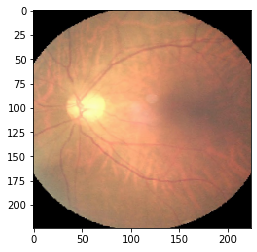

In [ ]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

## Augmented image examples

Let's make a grid of data augmented images

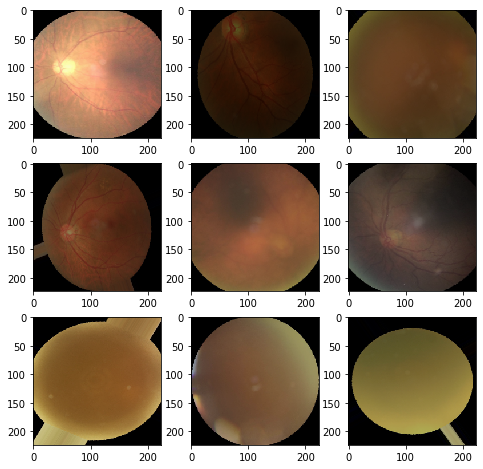

In [ ]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_image_data[i], interpolation='nearest')

plt.show()

### Model development

#### Build a transfer learning model

The VGG16 model is loaded for transfer learning without fully connecting the top layer using the include_top= FALSE hyperparameter.  

The 'imagenet' weights are used to find edges, corners, and rounded areas of the images.  Those are already embedded and can be sped up using its established functionality.


In [ ]:
base_model= VGG16(input_shape=(224, 224, 3),
                               weights='imagenet',
                               include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


#### Finetune the model

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

50% of the perceptrons will be dropped in  the last 2 layers to avoid overfitting.

The optimizer of choice is the Adam gradient descent.

In [ ]:
# New model
model= tf.keras.Sequential([base_model,
                            layers.Flatten(),
                            layers.Dense(1024, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(512, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(2, activation='softmax')])

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               6

#### Constants for training run

SPE is 'steps per epoch'

n_val_steps is 'number of validation steps'

In [ ]:
batch_size = 32
steps_per_epoch = train_generator.samples // batch_size
validation_steps = valid_generator.samples // batch_size
epochs = 10

In [ ]:
model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_generator,
          validation_steps=validation_steps,
          epochs=epochs,
          shuffle=True,
          workers=5,
          use_multiprocessing=True
          )

Epoch 1/10
21/21 [==============================] - 486s 22s/step - loss: 1.6803 - accuracy: 0.5038 - val_loss: 0.7070 - val_accuracy: 0.5750
Epoch 2/10
21/21 [==============================] - 444s 21s/step - loss: 0.8746 - accuracy: 0.5802 - val_loss: 0.5818 - val_accuracy: 0.6812
Epoch 3/10
21/21 [==============================] - 445s 21s/step - loss: 0.5757 - accuracy: 0.7099 - val_loss: 0.5940 - val_accuracy: 0.6687
Epoch 4/10
21/21 [==============================] - 439s 21s/step - loss: 0.4980 - accuracy: 0.7740 - val_loss: 0.4516 - val_accuracy: 0.7875
Epoch 5/10
21/21 [==============================] - 447s 21s/step - loss: 0.4638 - accuracy: 0.7756 - val_loss: 0.3864 - val_accuracy: 0.8000
Epoch 6/10
21/21 [==============================] - 447s 22s/step - loss: 0.4218 - accuracy: 0.8168 - val_loss: 0.4016 - val_accuracy: 0.8313
Epoch 7/10
21/21 [==============================] - 448s 21s/step - loss: 0.4607 - accuracy: 0.7954 - val_loss: 0.4375 - val_accuracy: 0.7937
Epoch 

#### Save the model

In [ ]:
from keras.models import save_model
save_model(model, 'ocmodel.h5')

#### Load saved model

In [ ]:
from keras.models import load_model
model = load_model('ocmodel.h5')

#### Make predictions with predict.generator


The prediction output is only a set of categorical labels of 0 and 1 where 0 = Cataract and 1 = Normal.

In [ ]:
x_test, y_test = test_generator.next()

In [ ]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

<ipython-input-44-f4d95dc2fe8f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


8/8 [==============================] - 148s 16s/step


#### Prediction raw data

Review output from predict generator to validate result

In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)

## Evaluate model's accuracy

In [ ]:
loss, accuracy= model.evaluate(test_generator,use_multiprocessing=True,workers=10)

9/9 [==============================] - 163s 18s/step - loss: 0.1893 - accuracy: 0.9371


In [ ]:
print("loss:",loss)
print("Accuracy:",accuracy)

loss: 0.18932278454303741
Accuracy: 0.9370629191398621


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
cf_matrix = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cf_matrix

Confusion Matrix


array([[129,  13],
       [  5, 139]])

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[129  13]
 [  5 139]]


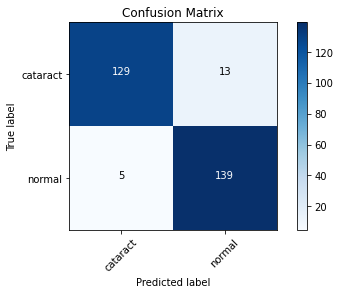

In [ ]:
plot_confusion_matrix(cm=cf_matrix, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

Use the training label string name keys (cataract and normal) and convert the one-hot encoded predicted class labels into string names.  What these lines do is grab the name of the category (the value) and place it into the predicted labels variable where it meets the criteria of the value.

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

## Build a new dataframe

We don't actually need to do this, but, building a new dataframe can be beneficial if you need to do any prediction lookups that require a dataframe, or you could export this out into a CSV.  Pretty handy to have around.

In [ ]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,2105_left.jpg,cataract
1,2119_right.jpg,cataract
2,2506_right.jpg,normal
3,2140_left.jpg,cataract
4,461_left.jpg,normal


## Verify prediction dataframe results

Since we want to prove that our test data is indeed being tested, let's verify that our prediction data is indeed aligned with the test filename, row and diagnosis.

In [ ]:
prediction_df.iloc[35]

Filename      16_left.jpg
Prediction         normal
Name: 35, dtype: object

Compare that same row to our test generator data

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

16_left.jpg
1


#### Image output of actual annotation and the prediction

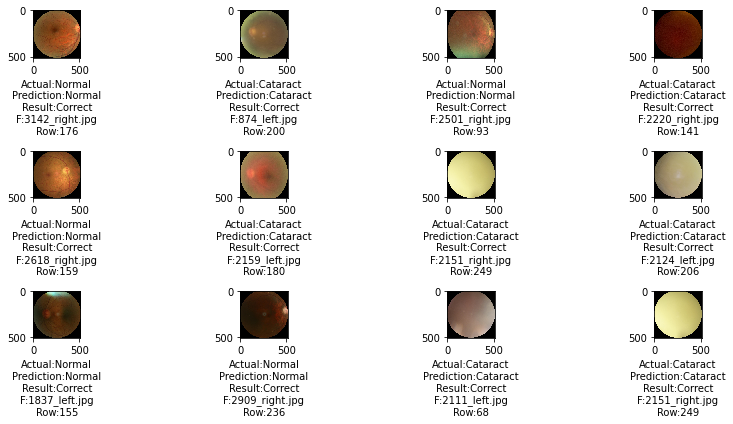

In [ ]:
plt.figure(figsize=(12,6))
for i in range(12):
    sample = random.choice(range(test_generator.samples))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]


    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"


    plt.subplot(3,4,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout()

#### Discussion

The model created uses VGG16 as the base model in addition to a number of dense layers to improve the depth and performance of the model. The model was compiled with the Adam optimizer, the loss function, with the performace metric being accuracy. The model's accuracy score is 0.8986 from the evaluation. The performance is very good as it only misclassified 29 of the 286 images used for testing.

### Conclusion

A machine learning model was developed to recognize eye diseases based on images. Ocular images were used to train the model to differentiate normal eye from cataract eye. Due to the high volume of normal data present, 572 images were chosen to match the number of cataract images present in the data.

A deep learning model was developed based on transfer learning and CNN. The VGG16 which is a complex model was used as the base model and topped up with dense layers. Upon evaluation, the model has a 89.86% accuracy is making the right prediction. 286 images were reserved for testing. From the confusion matrix, it can be observed that the model accurately classified 257 correctly and 29 in incorrectly. In this use case, the worse misclassification is the false positive (the number of cataract that was predicted as normal= 8).

The final display is a result of randomly selecting images from the test generator to show show the image of the eye, the actual annotation by medical experts and the prediction by the model. The model can be used by medical experts to aid the diagnosis of cataract quicker than the agonizing process of waiting to see experts.

In [ ]:
frozen_layers= 10
for layer in base_model.layers[:frozen_layers]:
  layer.trainable= False

In [ ]:
# Another model
prediction_layer= tf.keras.layers.Dense(2, activation='softmax')
model2= tf.keras.Sequential([base_model,
                             layers.Flatten(),
                             layers.Dense(256, activation='relu'),
                             layers.Dropout(0.5),
                             layers.Dense(256, activation='relu'),
                             layers.Dropout(0.5),
                             layers.Dense(64, activation='relu'),
                             prediction_layer])

optimizer = tf.keras.optimizers.Adadelta(0.001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [ ]:
model2.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_generator,
          validation_steps=validation_steps,
          epochs=epochs,
          shuffle=True,
          workers=5,
          use_multiprocessing=True
          )

Epoch 1/10
21/21 [==============================] - 456s 21s/step - loss: 0.8923 - accuracy: 0.5008 - val_loss: 0.7289 - val_accuracy: 0.5562
Epoch 2/10
21/21 [==============================] - 445s 21s/step - loss: 0.8534 - accuracy: 0.4809 - val_loss: 0.7104 - val_accuracy: 0.5938
Epoch 3/10
21/21 [==============================] - 452s 21s/step - loss: 0.8219 - accuracy: 0.5023 - val_loss: 0.7044 - val_accuracy: 0.5250
Epoch 4/10
21/21 [==============================] - 456s 22s/step - loss: 0.7990 - accuracy: 0.5130 - val_loss: 0.7005 - val_accuracy: 0.5063
Epoch 5/10
21/21 [==============================] - 449s 21s/step - loss: 0.7732 - accuracy: 0.5328 - val_loss: 0.6961 - val_accuracy: 0.5063
Epoch 6/10
21/21 [==============================] - 460s 22s/step - loss: 0.7614 - accuracy: 0.5160 - val_loss: 0.6942 - val_accuracy: 0.5250
Epoch 7/10
21/21 [==============================] - 455s 21s/step - loss: 0.7632 - accuracy: 0.5115 - val_loss: 0.6956 - val_accuracy: 0.4875
Epoch 

In [ ]:
pred2 = model2.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

<ipython-input-71-9f7d5ecdfb5c>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred2 = model2.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


8/8 [==============================] - 193s 18s/step


In [ ]:
predicted_class_idx2=np.argmax(pred2,axis=1)

In [ ]:
loss2, accuracy2= model2.evaluate(test_generator,use_multiprocessing=True,workers=10)

9/9 [==============================] - 163s 17s/step - loss: 0.6803 - accuracy: 0.5769


In [ ]:
print("loss:",loss2)
print("Accuracy:",accuracy2)

loss: 0.6802817583084106
Accuracy: 0.5769230723381042


Confusion Matrix
Confusion matrix, without normalization
[[ 36 106]
 [ 15 129]]


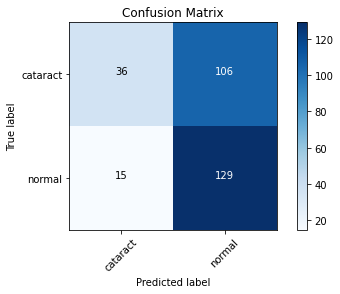

In [ ]:
cf_matrix2 = confusion_matrix(test_generator.labels, predicted_class_idx2)
print('Confusion Matrix')
plot_confusion_matrix(cm=cf_matrix2, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
model3 = tf.keras.Sequential([
                  layers.Conv2D(64, 3, activation='relu', \
                  input_shape=(224, 224 ,3)),\
                  layers.MaxPooling2D(),
                  layers.Conv2D(128, 3, activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dropout(0.5),
                  layers.Dense(512, activation='relu'),
                  layers.Dropout(0.5),
                  layers.Dense(256, activation='relu'),
                  layers.Dense(2, activation='softmax')])

optimizer = tf.keras.optimizers.Adam(0.001)
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

In [ ]:
model3.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_generator,
          validation_steps=validation_steps,
          epochs=epochs,
          shuffle=True,
          workers=5,
          use_multiprocessing=True
          )

Epoch 1/10
21/21 [==============================] - 172s 8s/step - loss: 0.6909 - accuracy: 0.5634 - val_loss: 0.6590 - val_accuracy: 0.6125
Epoch 2/10
21/21 [==============================] - 171s 8s/step - loss: 0.6660 - accuracy: 0.6275 - val_loss: 0.6711 - val_accuracy: 0.6062
Epoch 3/10
21/21 [==============================] - 164s 7s/step - loss: 0.6486 - accuracy: 0.6397 - val_loss: 0.6521 - val_accuracy: 0.6187
Epoch 4/10
21/21 [==============================] - 162s 7s/step - loss: 0.5986 - accuracy: 0.6931 - val_loss: 0.6365 - val_accuracy: 0.6750
Epoch 5/10
21/21 [==============================] - 163s 7s/step - loss: 0.6404 - accuracy: 0.6443 - val_loss: 0.6623 - val_accuracy: 0.6187
Epoch 6/10
21/21 [==============================] - 171s 8s/step - loss: 0.6271 - accuracy: 0.6641 - val_loss: 0.6325 - val_accuracy: 0.6250
Epoch 7/10
21/21 [==============================] - 164s 8s/step - loss: 0.6157 - accuracy: 0.6748 - val_loss: 0.5947 - val_accuracy: 0.6750
Epoch 8/10
21

In [ ]:
pred3 = model3.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

<ipython-input-86-ed4618f2727d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred3 = model3.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


8/8 [==============================] - 19s 2s/step


In [ ]:
predicted_class_idx3=np.argmax(pred3,axis=1)

In [ ]:
loss3, accuracy3= model3.evaluate(test_generator,use_multiprocessing=True,workers=10)

9/9 [==============================] - 25s 2s/step - loss: 0.5782 - accuracy: 0.6993


Confusion Matrix
Confusion matrix, without normalization
[[100  42]
 [ 44 100]]


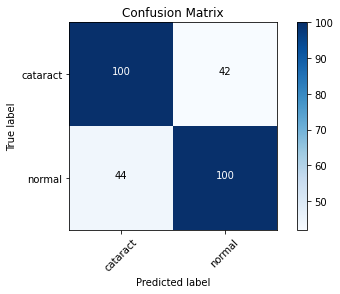

In [ ]:
cf_matrix3 = confusion_matrix(test_generator.labels, predicted_class_idx3)
print('Confusion Matrix')
plot_confusion_matrix(cm=cf_matrix3, classes=cm_plot_labels, title='Confusion Matrix')